### Simulating selection 
여기서 해볼것, 

1. simple case with dominant mutation on a single loci.
2. complex case with two lociusing epistatic effects.

#### example
 : of malaria resistance to the sulfadoxine/pyrimethamine drug => DHFR gene
 

In [1]:
from collections import OrderedDict
from copy import deepcopy

import seaborn as sns
import matplotlib.pyplot as plt

import simuPOP as sp
%matplotlib inline

simuPOP Version 1.1.6 : Copyright (c) 2004-2011 Bo Peng
Revision 4972 (May  1 2015) for Python 2.7.9 (64bit, 1thread)
Random Number Generator is set to mt19937 with random seed 0x94c596adb4de5de3.
This is the standard short allele version with 256 maximum allelic states.
For more information, please visit http://simupop.sourceforge.net,
or email simupop-list@lists.sourceforge.net (subscription required).


/home/seung-hyun/anaconda/envs/bioinformatics/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
num_loci = 10
pop_size = 1000
num_gens = 101

In [3]:
init_ops = OrderedDict()
pre_ops = OrderedDict()
post_ops = OrderedDict()

In [4]:
def init_accumulators(pop, param):
    accumulators = param
    for accumulator in accumulators:
        pop.vars()[accumulator] = []
    return True

def update_accumulator(pop, param):
    accumulator, var = param
    pop.vars()[accumulator].append(deepcopy(pop.vars()[var]))
    return True

In [5]:
pops = sp.Population(pop_size, loci=[1] * num_loci, infoFields=['fitness'])

# There is now an infoFields parameter in the population.
# population 에 대한 variables, individual 에 대한 variables 을 각각 가질수 있기 때문에.
# simulate a fairly big population (1000) to avoid drift effects

In [6]:
# initialization 에 아래의 함수를 이용, 우리가 보고자 하는 loci 를 선택한다. (selection)
# 아까 사용하였던, InitGenotype 은 neutral marker임.

def create_derived_by_count(pop, param):
    #Assumes everything is autosomal and that derived is low (<0.5)
    locus, cnt = param
    for i, ind in enumerate(pop.individuals()):
        for marker in range(pop.totNumLoci()):
            if i < cnt and locus == marker:
                ind.setAllele(1, marker, 0)
            else:
                ind.setAllele(0, marker, 0)
            ind.setAllele(0, marker, 1)
    return True

In [7]:
init_ops['Sex'] = sp.InitSex()
init_ops['Freq-sel'] = sp.PyOperator(create_derived_by_count, param=(0, 10))
#careful above
init_ops['Freq-neutral'] = sp.InitGenotype(freq=[0.5, 0.5], loci=range(1, num_loci))
post_ops['Stat-freq'] = sp.Stat(alleleFreq=sp.ALL_AVAIL)
post_ops['Stat-freq-eval'] = sp.PyEval(r"'%d %.3f\n' % (gen, alleleFreq[0][1])", reps=[0], step=10)



# MapSelector  
각 genotype 에 대한 fitness values 를 제공하는 python Dictionary.  
dictionary 는 다음의 keys (0,0), (0,1) and (1,1) 와 specify fitness values 로 구성.


## Multi-allele selector (operator MaSelector)
## Multi-locus selection models (operator MlSelector)
## A hybrid selector (operator PySelector)
## Multi-locus random fitness effects (operator PyMlSelector)


In [8]:
# We create a fitness operator that will compute the fitness parameter for each individual with a dominant encoding.
ms = sp.MapSelector(loci=0, fitness={
                (0, 0): 0.90,
                (0, 1): 1,
                (1, 1): 1})
pre_ops['Selection'] = ms # Natural selection through the selection of parents (부모의 selection이다.)
# 만약 offsprings 를 selection 하려면

# matingScheme=sim.RandomMating(ops=[
#         sim.MendelianGenoTransmitter(),
#         sim.MapSelector(loci=0, fitness={(0,0):1, (0,1):0.98, (1,1):0.97}) 이런식으로.....

mating_scheme = sp.RandomMating()

In [9]:
# selection 된 allele의 frequency를 아래 함수를 이용해 저장.

def get_freq_deriv(pop, param):
    marker, name = param
    expHe = {}
    pop.vars()[name] = pop.dvars().alleleFreq[marker][1]
    return True

In [10]:
init_ops['accumulators'] = sp.PyOperator(init_accumulators, param=['freq_sel'])
post_ops['FreqSel'] = sp.PyOperator(get_freq_deriv, param=(0, 'freqDeriv'))
post_ops['freq_sel_accumulation'] = sp.PyOperator(update_accumulator, param=('freq_sel', 'freqDeriv'))

In [11]:
sim = sp.Simulator(pops, rep=100)  # we will run 100 replicates: talk about threads
sim.evolve(initOps=init_ops.values(), preOps=pre_ops.values(), postOps=post_ops.values(),
           matingScheme=mating_scheme, gen=num_gens)
None

0 0.004
10 0.000
20 0.000
30 0.000
40 0.000
50 0.000
60 0.000
70 0.000
80 0.000
90 0.000
100 0.000


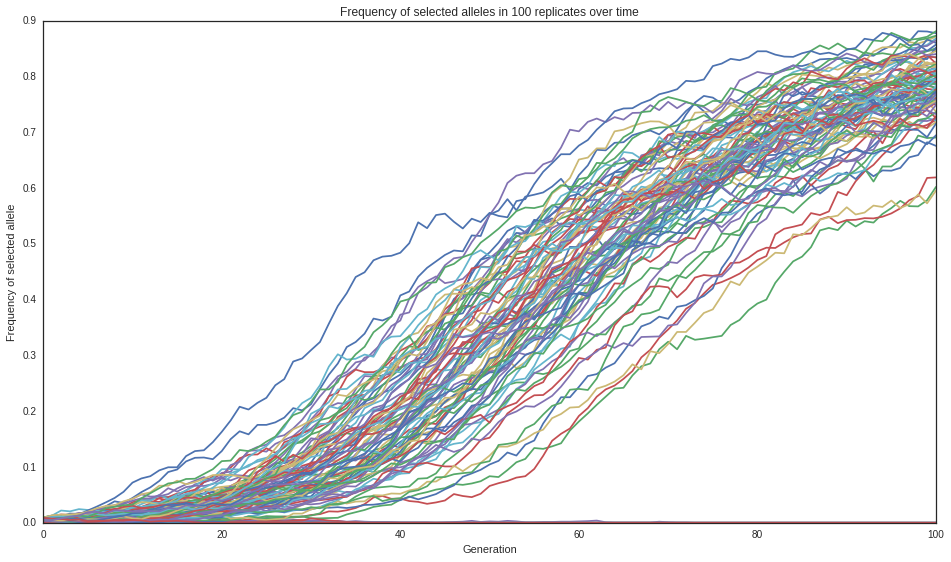

In [13]:
sns.set_style('white')
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
ax.set_title('Frequency of selected alleles in 100 replicates over time')
ax.set_xlabel('Generation')
ax.set_ylabel('Frequency of selected allele')
for pop in sim.populations():
    ax.plot(pop.vars()['freq_sel'])

In [14]:
pop_size = 100 # size 가 작아 genetic drift 가 일어난다.
pops = sp.Population(pop_size, loci=[1] * num_loci, infoFields=['fitness'])

In [15]:
init_ops['Freq-sel'] = sp.PyOperator(create_derived_by_count, param=(0, 1))
sim = sp.Simulator(pops, rep=100)  # talk about threads
sim.evolve(initOps=init_ops.values(), preOps=pre_ops.values(), postOps=post_ops.values(),
           matingScheme=mating_scheme, gen=num_gens)
None

0 0.005
10 0.000
20 0.000
30 0.000
40 0.000
50 0.000
60 0.000
70 0.000
80 0.000
90 0.000
100 0.000


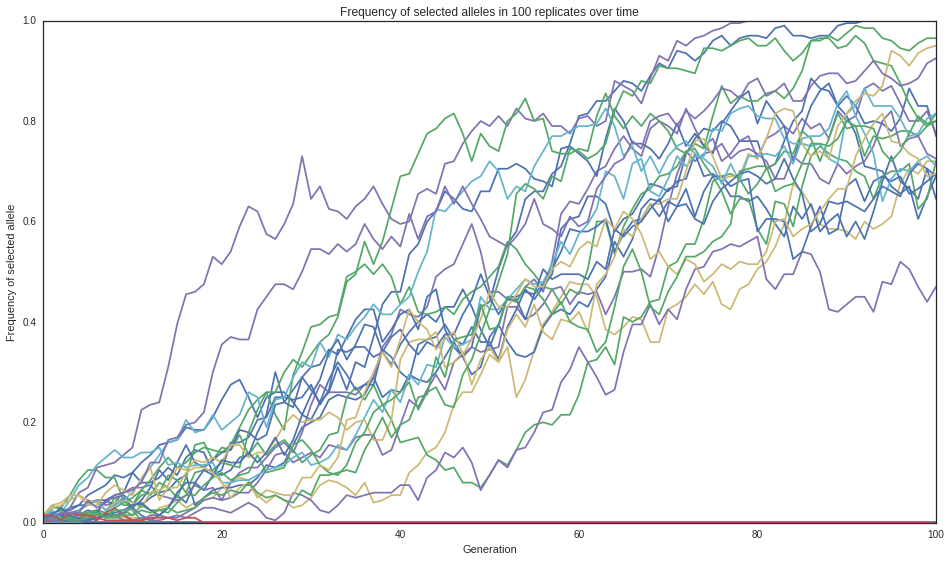

In [17]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
ax.set_xlabel('Generation')
ax.set_ylabel('Frequency of selected allele')
ax.set_title('Frequency of selected alleles in 100 replicates over time')
for pop in sim.populations():
    ax.plot(pop.vars()['freq_sel'])

In [18]:
#suggest comparing with neutral

In [19]:
hz_ms = sp.MapSelector(loci=0, fitness={
                (0, 0): 0.9,
                (0, 1): 0.9,
                (1, 1): 1})
hz_mating_scheme = sp.RandomMating(ops=[sp.MendelianGenoTransmitter(), hz_ms])

In [20]:
recessive_ms = sp.MapSelector(loci=0, fitness={
                (0, 0): 0.9,
                (0, 1): 0.9,
                (1, 1): 1})
recessive_mating_scheme = sp.RandomMating(ops=[sp.MendelianGenoTransmitter(), recessive_ms])

In [21]:
# talk about multi-loci

In [22]:
pop_size = 5000
num_gens = 100
pops = sp.Population(pop_size, loci=[1] * num_loci, infoFields=['fitness'])

In [23]:
def example_epistasis(geno):
    if geno[0] + geno[1] == 0:
        return 0.7
    elif geno[2] + geno[3] == 0:
        return 0.8
    else:
        return 0.9 + 0.1 * (geno[2] + geno[3] - 1)
    
# 0.7 if it does not have the derived allele at the main loci
# 0.8 if it has the derived allele at the main loci, but no derived allele at the secondary loci
# 0.9 if it has one derived secondary loci

In [24]:
init_ops = OrderedDict()
pre_ops = OrderedDict()
post_ops = OrderedDict()
init_ops['Sex'] = sp.InitSex()
init_ops['Freq-sel'] = sp.InitGenotype(freq=[0.99, 0.01], loci=[0, 1])
# selected loci : 1%
init_ops['Freq-neutral'] = sp.InitGenotype(freq=[0.5, 0.5], loci=range(2, num_loci))
# neutral loci : 50% 
pre_ops['Selection'] = sp.PySelector(loci=[0, 1], func=example_epistasis)
init_ops['accumulators'] = sp.PyOperator(init_accumulators, param=['freq_sel_major', 'freq_sel_minor'])
post_ops['Stat-freq'] = sp.Stat(alleleFreq=sp.ALL_AVAIL)
post_ops['FreqSelMajor'] = sp.PyOperator(get_freq_deriv, param=(0, 'FreqSelMajor'))
post_ops['FreqSelMinor'] = sp.PyOperator(get_freq_deriv, param=(1, 'FreqSelMinor'))
post_ops['freq_sel_major_accumulation'] = sp.PyOperator(update_accumulator,
                                                        param=('freq_sel_major', 'FreqSelMajor'))
post_ops['freq_sel_minor_accumulation'] = sp.PyOperator(update_accumulator,
                                                        param=('freq_sel_minor', 'FreqSelMinor'))

In [25]:
sim = sp.Simulator(pops, rep=15)
sim.evolve(initOps=init_ops.values(), preOps=pre_ops.values(), postOps=post_ops.values(),
           matingScheme=mating_scheme, gen=num_gens)
None

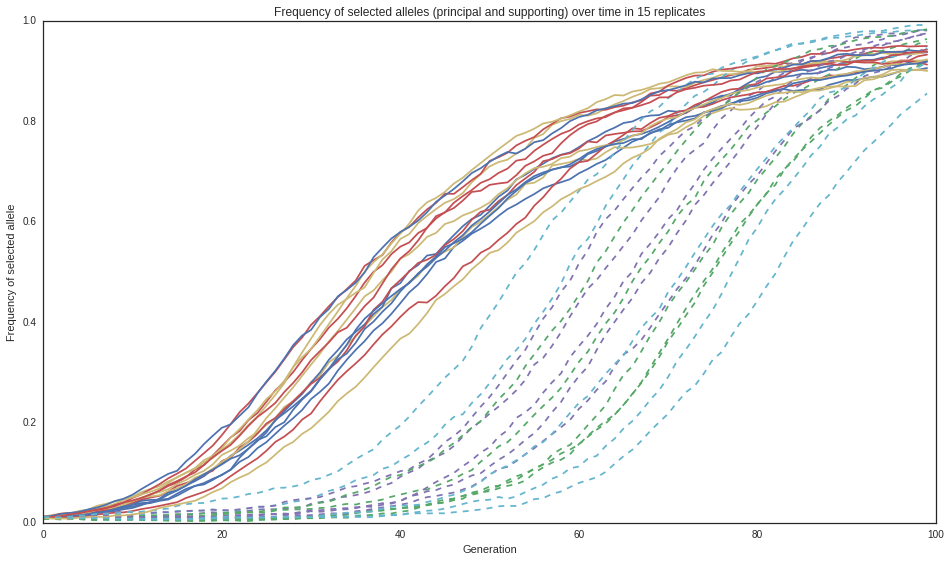

In [26]:
fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Generation')
ax1.set_ylabel('Frequency of selected allele')
ax1.set_title('Frequency of selected alleles (principal and supporting) over time in 15 replicates')
for pop in sim.populations():
    ax1.plot(pop.vars()['freq_sel_major'])
    ax1.plot(pop.vars()['freq_sel_minor'], '--')
    
# main allele is coded with a straight line
# the secondary allele as a dashed line
